### Demeaning then smoothing or the other way round?

Mohsin Javed, June 9, 2020

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
FS = (10, 8)

Given a time series $x_t$, and window lengths $M, N$, we want to understand the difference between the following two procedures.

1. First demean $x_t$ using an $M$-point moving average and then take an $N$-point moving average to smooth the result.
2. First smooth $x_t$ by using an $N$-point moving average and then demain the result using an $M$-point moving average.

To set the notation, let $x_t$ be a discrete time series of length $n$, that is, the subscript $t$ belongs to the set $\{0, 1, \ldots, n-1\}$.

The $M$-point moving average of $x_t$ can be described as a linear operator on $x_t$, in other words by a matrix multiplication. If $y_t$ is the $M$-point moving average of $x_t$, we have:

\begin{align*}
y_t = A_{M} x_t,
\end{align*}

where $A_{M}$ is $n \times n$ banded 
matrix with ones on the top $M$ diagonals
scaled by $1/M$. For example, if all 
our time series are of length $n=5$, then,

\begin{align*}
A_{3} =
\frac{1}{3}
\begin{bmatrix}
1 & 1 & 1 & 0 & 0\\
0 & 1 & 1 & 1 & 0\\
0 & 0 & 1 & 1 & 1\\
0 & 0 & 0 & 1 & 1\\
0 & 0 & 0 & 0 & 1
\end{bmatrix}
\end{align*}

Note that in the case of a weighted moving average prescribed be weights $\{w_1, w_2, \ldots, w_M\}$, the structure of the above matrix would remain the same, the $M$ non-uniform weights will occupy the $M$ diagonals in the matrix above and the scaling factor will by $1/\sum_{i=1}^{M}{w_i}$


With the notation above, we now consider the two cases of intesest. 

Let $y^{sd}_t$ be the series obtained by first demeaning and then smoothing:

\begin{align*}
y^{sd} &= A_{N}(x_t - A_{M}x_t)\\
&= A_{N}x_t - A_{N}A_{M}x_t.
\end{align*}

On the other hand, let $y^{ds}$ be the $N$-point smoothing of $x_t$ followed be $M$-point moving 
average demeaning of the smoothened result:

\begin{align*}
y^{ds} &= A_{N}(x_t) - A_{M}(A_{N}x_t)\\
&= A_{N}x_t - A_{M}A_{N}x_t,
\end{align*}

The difference betweent the two approaches boils down to wether $A_{N}$ and $A_{M}$
commute or not:

\begin{align*}
y^{sd} - y^{ds} &= A_{N}A_{M}x_t - A_{M}A_{N}x_t \\
                &= (A_{N}A_{M} - A_{M}A_{N})x_t \\
\end{align*}

In general, the moving average matrices do not commute:

\begin{align*}
A_{N}A_{M} \neq A_{M}A_{N},
\end{align*}

however, the difference might not be significant.

The following code produces $A_M$ of size $n \times n$:

In [4]:
def moving_average_matrix(n, M):
    """Moving average matrix. Assumes that the 
    time series on which this matrix will be applied has 
    total length n to compute M point averages.
    
    returns a n x n matrix with non zero entries in the M diagonals
    """
    assert M <= n
    out = np.zeros((n, n))
    
    # 1. this method has all zeros in the last M - 1 rows
    #  for k in range(n-M+1):
    #   out[k, k:k+M] = np.ones(M)
    #  return 1.0 / M * out

    # 2. This method slowly builds the moving average for the first M-1 points
    for k in range(M):
        out = out + np.diag(np.ones(n-k), k)
    
    for k in range(n):
        out[k, :] = out[k, :] / np.sum(out[k, :])
    return out


As an example, we create a $5 \times 5$ matrix for a $3$-point average:

In [5]:
n, M = 5, 3
A = moving_average_matrix(n, M)
A

array([[0.33333333, 0.33333333, 0.33333333, 0.        , 0.        ],
       [0.        , 0.33333333, 0.33333333, 0.33333333, 0.        ],
       [0.        , 0.        , 0.33333333, 0.33333333, 0.33333333],
       [0.        , 0.        , 0.        , 0.5       , 0.5       ],
       [0.        , 0.        , 0.        , 0.        , 1.        ]])

The operator $A_{M}A_{N} - A_{N}A_{M}$ is not exactly zero but quite sparse:

In [6]:
A = lambda M: moving_average_matrix(10, M)
D = A(6) @ A(3) - A(3) @ A(6)

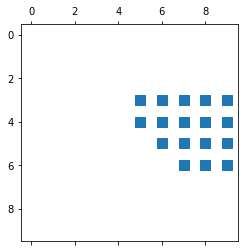

In [7]:
import scipy.sparse as sps
Ds = sps.csr_matrix(D)
plt.spy(Ds)
plt.show()

To apply the moving point average on a time series $x_t$, we just have to say:

In [9]:
n = 100
x = np.cumsum(np.random.randn(n))
A = lambda M: moving_average_matrix(n, M)
M = 10
ma_x = np.flipud(A(M) @ np.flipud(x))

The beginning part of the original time series and its moving average

In [15]:
df = pd.DataFrame({'xt': x, f'ma_xt_{M}': ma_x})
df.head(M+10)

,xt,ma_xt_10
0,0.508284,0.508284
1,2.505286,1.506785
2,0.076895,1.030155
3,-0.224202,0.716566
4,-1.516424,0.269968
5,-2.367339,-0.169583
6,-2.789468,-0.543852
7,-2.714422,-0.815174
8,-1.961446,-0.942537
9,0.183498,-0.829934


And a plot of the two

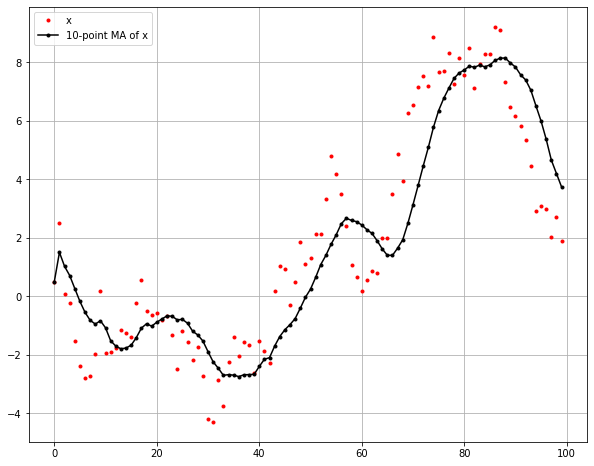

In [16]:
plt.figure(figsize=FS)
plt.plot(np.arange(n), x, 'r.', np.arange(n), ma_x, 'k.-')
plt.legend(['x', f'{M}-point MA of x'])
plt.grid(True)

Now let's compute $y^{sd}$ and $y^{ds}$, with demeaning window $M$ and smoothing 
window $N$.

In [17]:
MA = lambda x, M: np.flipud(moving_average_matrix(n, M) @ np.flipud(x))
M, N = 30, 40
ysd = MA(x - MA(x, M), N)
yds = MA(x, N) - MA(MA(x, N), M)

In [19]:
df['ysd'] = ysd
df['yds'] = yds
df

,xt,ma_xt_10,ysd,yds
0,0.508284,0.508284,0.000000,0.000000
1,2.505286,1.506785,0.499250,0.499250
2,0.076895,1.030155,0.015080,0.015080
3,-0.224202,0.716566,-0.223882,-0.223882
4,-1.516424,0.269968,-0.536384,-0.536384
...,...,...,...,...
95,3.077440,5.992403,2.163068,2.163068
96,2.996011,5.369883,1.972277,1.972277
97,2.031795,4.661268,1.790567,1.790567
98,2.724105,4.201469,1.662371,1.662371


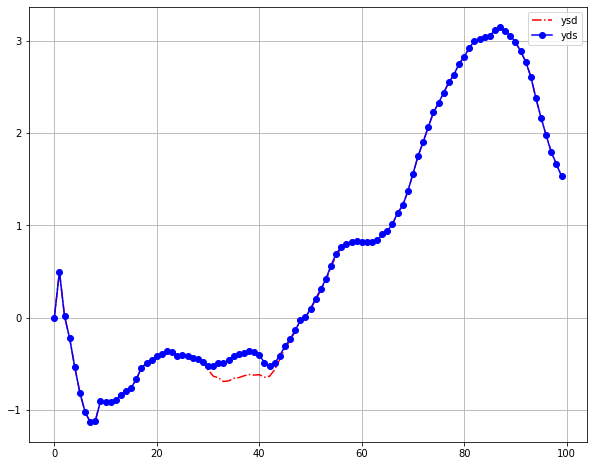

In [20]:
plt.figure(figsize=FS)
plt.plot(np.arange(n), ysd, 'r-.', np.arange(n), yds, 'b-o')
plt.legend(['ysd', 'yds'])
plt.grid(True)

Let's also look at the difference

Text(0.5, 1.0, 'ysd - yds')

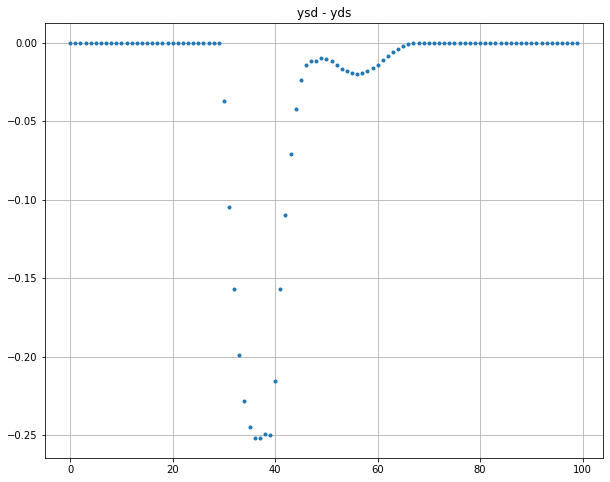

In [21]:
df['ysd-yds'] = df['ysd'] - df['yds']
plt.figure(figsize=FS)
plt.plot(np.arange(n), ysd - yds, '.')
plt.grid(True)
plt.title('ysd - yds')

In [22]:
np.abs(ysd - yds) > 1e-10

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

It's quite interesting to see the operator $A_{M}A_{N} - A_{N}A_{M}$. It's largely sparse, with
very few entries contrubuting to the difference. 

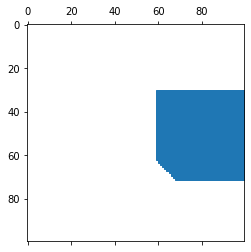

In [23]:
A = lambda M: moving_average_matrix(len(x), M)
D = A(M)@A(N) - A(N)@A(M)
Ds = sps.csr_matrix(D)
plt.spy(Ds)
plt.show()